Import necessary dependencies

In [14]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
import torch
from torch import optim
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

In [15]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [16]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
# elif torch.backends.mps.is_available():
#     device = torch.device("mps:0")
else:
    device = torch.device("cpu")

Load data

In [17]:
data = pd.read_csv('IoT_Modbus.csv')

# TODO: Complete EDA

Combine 'date' and 'time' into a single datetime column

In [18]:
data['datetime'] = pd.to_datetime(data['date'] + ' ' + data['time'])

/var/folders/qx/28c_j79n3zn_3rkwzsdcmn240000gn/T/ipykernel_73779/2882021498.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['datetime'] = pd.to_datetime(data['date'] + ' ' + data['time'])


Extract time features

In [19]:
data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour
data['minute'] = data['datetime'].dt.minute
data['second'] = data['datetime'].dt.second
data['dayofweek'] = data['datetime'].dt.dayofweek

Time series models need to ensure that the data set is arranged in time order

In [20]:
# Sort the data by datetime
data = data.sort_values(by='datetime')

# Drop the original date, time, and timestamp columns
data.drop(['date', 'time', 'datetime', 'type'], axis=1, inplace=True)

# Adjust feature order
order = ['year', 'month', 'day', 'hour', 'minute', 'second', 'dayofweek', 'FC1_Read_Input_Register', 'FC2_Read_Discrete_Value', 'FC3_Read_Holding_Register', 'FC4_Read_Coil', 'label']
data = data[order].astype('int32')

# Split the dataset (Sequential Split)

In [21]:
# Calculate split points
split_idx = int(len(data) * 0.8)

# Split the data set, keeping order
train_data = data.iloc[:split_idx]
test_data = data.iloc[split_idx:]

# Separate features and labels
X_train = train_data.drop('label', axis=1)
y_train = train_data['label']
X_test = test_data.drop('label', axis=1)
y_test = test_data['label']

# Data preprocessing (Normalization)

In [22]:
feature_columns = [col for col in X_train.columns if col != 'label']
scaler = MinMaxScaler()
X_train[feature_columns] = scaler.fit_transform(X_train[feature_columns]).astype('float32')
X_test[feature_columns] = scaler.transform(X_test[feature_columns]).astype('float32')
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 229755 entries, 541 to 184368
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   year                       229755 non-null  float32
 1   month                      229755 non-null  float32
 2   day                        229755 non-null  float32
 3   hour                       229755 non-null  float32
 4   minute                     229755 non-null  float32
 5   second                     229755 non-null  float32
 6   dayofweek                  229755 non-null  float32
 7   FC1_Read_Input_Register    229755 non-null  float32
 8   FC2_Read_Discrete_Value    229755 non-null  float32
 9   FC3_Read_Holding_Register  229755 non-null  float32
 10  FC4_Read_Coil              229755 non-null  float32
dtypes: float32(11)
memory usage: 11.4 MB


# Execution model
## Create model

In [23]:
class LightweightLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, width_multiplier=1.0):
        super(LightweightLSTM, self).__init__()
        # Adjust hidden size based on the width multiplier
        adjusted_hidden_size = int(hidden_size * width_multiplier)

        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size, adjusted_hidden_size, num_layers=num_layers, batch_first=True)

        self.linear_1 = nn.Linear(adjusted_hidden_size, hidden_size)
        self.linear_2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # LSTM layer
        lstm_out, _ = self.lstm(x)

        # Take the output of the last time step
        last_time_step_out = lstm_out[:, -1, :]

        # Output layer
        x = self.linear_1(last_time_step_out)
        out = self.linear_2(x)
        return out

Initialize model

In [24]:
features_num = X_train.shape[1]
hidden_neurons_num = 512
output_neurons_num = 1
lstm_num_layers = 2
multiplier = 0.5

model = LightweightLSTM(features_num, hidden_neurons_num, output_neurons_num, lstm_num_layers, multiplier).to(device)

In [ ]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device=device)

Build loss functions and optimizers

In [25]:
weights = torch.tensor([1, class_weights[1]], dtype=torch.float)
criterion = nn.BCEWithLogitsLoss(pos_weight=weights).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)

Construct Data Loader

In [26]:
batch_size = 128
X_train_tensor = torch.tensor(X_train.values).float().unsqueeze(1).to(device)
y_train_tensor = torch.tensor(y_train.values).float().unsqueeze(1).to(device)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

Training model

In [27]:
num_epochs = 100
pbar = tqdm(total=num_epochs)
loss_list = [None] * num_epochs
acc_list = [None] * num_epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    times = 0

    for inputs, labels in train_loader:
        # FP
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # BP and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate indicators
        model.eval()
        with torch.no_grad():
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > 0.5).float().cpu().numpy()

            # Calculate indicators
            y = labels.cpu().numpy()
            running_loss += loss.item() * inputs.size(0)
            running_accuracy += accuracy_score(y, predictions)
            times += 1
            
    epoch_loss = running_loss / len(train_loader.dataset)
    accuracy = running_accuracy / times
    loss_list[epoch] = epoch_loss
    acc_list[epoch] = accuracy
    
    pbar.update(1)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}, Accuracy: {accuracy}')
pbar.reset()


 15%|█▌        | 15/100 [03:36<20:26, 14.43s/it]

  1%|          | 1/100 [00:11<19:31, 11.83s/it]

Epoch [1/100], Loss: 0.2549510878632142, Accuracy: 0.8885880919220056



  2%|▏         | 2/100 [00:24<19:52, 12.17s/it]

Epoch [2/100], Loss: 0.31070770624866056, Accuracy: 0.8424921657381615



  3%|▎         | 3/100 [00:36<19:50, 12.28s/it]

Epoch [3/100], Loss: 0.27627707718200795, Accuracy: 0.8737465181058496



  4%|▍         | 4/100 [00:49<19:50, 12.40s/it]

Epoch [4/100], Loss: 0.2729166402102378, Accuracy: 0.8763187674094708



  5%|▌         | 5/100 [01:01<19:47, 12.50s/it]

Epoch [5/100], Loss: 0.27459609597676216, Accuracy: 0.8790215877437326



  6%|▌         | 6/100 [01:14<19:37, 12.52s/it]

Epoch [6/100], Loss: 0.2667325717672898, Accuracy: 0.8848494080779944



  7%|▋         | 7/100 [01:26<19:19, 12.47s/it]

Epoch [7/100], Loss: 0.2701337044491922, Accuracy: 0.8874390668523677



  8%|▊         | 8/100 [01:39<19:04, 12.44s/it]

Epoch [8/100], Loss: 0.27451334716242287, Accuracy: 0.8831650417827298



  9%|▉         | 9/100 [01:51<18:43, 12.35s/it]

Epoch [9/100], Loss: 0.2722604784987458, Accuracy: 0.8780379526462395



 10%|█         | 10/100 [02:03<18:18, 12.20s/it]

Epoch [10/100], Loss: 0.27225468428398797, Accuracy: 0.8812761142061282



 11%|█         | 11/100 [02:15<18:06, 12.21s/it]

Epoch [11/100], Loss: 0.268003570958699, Accuracy: 0.8805753830083566



 12%|█▏        | 12/100 [02:27<17:54, 12.21s/it]

Epoch [12/100], Loss: 0.2773964203856238, Accuracy: 0.8799965181058496



 13%|█▎        | 13/100 [02:39<17:42, 12.22s/it]

Epoch [13/100], Loss: 0.25775644293463806, Accuracy: 0.895512708913649



 14%|█▍        | 14/100 [02:51<17:18, 12.08s/it]

Epoch [14/100], Loss: 0.2487149907801536, Accuracy: 0.9016190807799442



 15%|█▌        | 15/100 [03:03<16:58, 11.98s/it]

Epoch [15/100], Loss: 0.24712787374684292, Accuracy: 0.9009575208913649



 16%|█▌        | 16/100 [03:15<16:41, 11.92s/it]

Epoch [16/100], Loss: 0.24146264450494512, Accuracy: 0.9023198119777158



 17%|█▋        | 17/100 [03:26<16:25, 11.87s/it]

Epoch [17/100], Loss: 0.23702695507911434, Accuracy: 0.9059932103064067



 18%|█▊        | 18/100 [03:38<16:09, 11.83s/it]

Epoch [18/100], Loss: 0.23313229546379247, Accuracy: 0.9079430710306406



 19%|█▉        | 19/100 [03:50<15:55, 11.79s/it]

Epoch [19/100], Loss: 0.22077329209486846, Accuracy: 0.9116208217270195



 20%|██        | 20/100 [04:02<15:47, 11.85s/it]

Epoch [20/100], Loss: 0.22531880334603682, Accuracy: 0.9144280988857939



 21%|██        | 21/100 [04:15<15:57, 12.12s/it]

Epoch [21/100], Loss: 0.21170204625922845, Accuracy: 0.9173485376044568



 22%|██▏       | 22/100 [04:27<16:02, 12.34s/it]

Epoch [22/100], Loss: 0.2110835944103574, Accuracy: 0.9197641016713092



 23%|██▎       | 23/100 [04:40<16:03, 12.51s/it]

Epoch [23/100], Loss: 0.2089235889017339, Accuracy: 0.9212047353760445



 24%|██▍       | 24/100 [04:53<16:00, 12.64s/it]

Epoch [24/100], Loss: 0.20930341423067847, Accuracy: 0.9206171657381615



 25%|██▌       | 25/100 [05:06<15:43, 12.58s/it]

Epoch [25/100], Loss: 0.21032826858230377, Accuracy: 0.9236638231197771



 26%|██▌       | 26/100 [05:18<15:28, 12.54s/it]

Epoch [26/100], Loss: 0.20207411903339623, Accuracy: 0.9233286908077994



 27%|██▋       | 27/100 [05:31<15:13, 12.52s/it]

Epoch [27/100], Loss: 0.204589913886776, Accuracy: 0.9227411211699165



 28%|██▊       | 28/100 [05:43<15:02, 12.53s/it]

Epoch [28/100], Loss: 0.20763637444438612, Accuracy: 0.9238422701949861



 29%|██▉       | 29/100 [05:56<14:45, 12.47s/it]

Epoch [29/100], Loss: 0.20191546643444597, Accuracy: 0.9233896239554318



 30%|███       | 30/100 [06:08<14:34, 12.49s/it]

Epoch [30/100], Loss: 0.20662998530381385, Accuracy: 0.9232982242339833



 31%|███       | 31/100 [06:20<14:09, 12.32s/it]

Epoch [31/100], Loss: 0.20510026419481558, Accuracy: 0.9222536559888579



 32%|███▏      | 32/100 [06:33<14:03, 12.40s/it]

Epoch [32/100], Loss: 0.20920795748404794, Accuracy: 0.9213962395543176



 33%|███▎      | 33/100 [06:45<13:51, 12.41s/it]

Epoch [33/100], Loss: 0.20819337821319148, Accuracy: 0.9207259749303621



 34%|███▍      | 34/100 [06:57<13:39, 12.42s/it]

Epoch [34/100], Loss: 0.21164834516996442, Accuracy: 0.9196248259052925



 35%|███▌      | 35/100 [07:10<13:35, 12.54s/it]

Epoch [35/100], Loss: 0.2098807484068514, Accuracy: 0.9188762186629527



 36%|███▌      | 36/100 [07:23<13:30, 12.67s/it]

Epoch [36/100], Loss: 0.2127537312481505, Accuracy: 0.9180057451253482



 37%|███▋      | 37/100 [07:37<13:29, 12.86s/it]

Epoch [37/100], Loss: 0.21179257415385622, Accuracy: 0.916978586350975



 38%|███▊      | 38/100 [07:48<12:59, 12.57s/it]

Epoch [38/100], Loss: 0.212649118989082, Accuracy: 0.9176444986072423



 39%|███▉      | 39/100 [08:00<12:34, 12.36s/it]

Epoch [39/100], Loss: 0.210544219355629, Accuracy: 0.917400766016713



 40%|████      | 40/100 [08:12<12:15, 12.26s/it]

Epoch [40/100], Loss: 0.2094239970173886, Accuracy: 0.9189806754874652



 41%|████      | 41/100 [08:25<12:10, 12.38s/it]

Epoch [41/100], Loss: 0.20424466769275532, Accuracy: 0.9211438022284123



 42%|████▏     | 42/100 [08:37<11:58, 12.38s/it]

Epoch [42/100], Loss: 0.2001142037252554, Accuracy: 0.9237682799442897



 43%|████▎     | 43/100 [08:49<11:38, 12.25s/it]

Epoch [43/100], Loss: 0.1949667045855604, Accuracy: 0.9262621866295264



 44%|████▍     | 44/100 [09:02<11:28, 12.30s/it]

Epoch [44/100], Loss: 0.19057144914078786, Accuracy: 0.928904073816156



 45%|████▌     | 45/100 [09:14<11:21, 12.39s/it]

Epoch [45/100], Loss: 0.18464665112091871, Accuracy: 0.931445856545961



 46%|████▌     | 46/100 [09:27<11:17, 12.55s/it]

Epoch [46/100], Loss: 0.1792873703241134, Accuracy: 0.9342923050139276



 47%|████▋     | 47/100 [09:39<10:59, 12.44s/it]

Epoch [47/100], Loss: 0.17768489078529745, Accuracy: 0.9358025766016713



 48%|████▊     | 48/100 [09:52<10:42, 12.35s/it]

Epoch [48/100], Loss: 0.17275098090752422, Accuracy: 0.9380048746518106



 49%|████▉     | 49/100 [10:04<10:24, 12.24s/it]

Epoch [49/100], Loss: 0.16932661038503793, Accuracy: 0.9394933844011142



 50%|█████     | 50/100 [10:16<10:14, 12.29s/it]

Epoch [50/100], Loss: 0.1674774870059115, Accuracy: 0.939828516713092



 51%|█████     | 51/100 [10:28<10:04, 12.34s/it]

Epoch [51/100], Loss: 0.16674958495707332, Accuracy: 0.940028725626741



 52%|█████▏    | 52/100 [10:41<09:55, 12.41s/it]

Epoch [52/100], Loss: 0.16614717640359403, Accuracy: 0.9400200208913649



 53%|█████▎    | 53/100 [10:53<09:38, 12.31s/it]

Epoch [53/100], Loss: 0.16508997948942672, Accuracy: 0.9398328690807799



 54%|█████▍    | 54/100 [11:05<09:24, 12.28s/it]

Epoch [54/100], Loss: 0.16435175446743094, Accuracy: 0.9398024025069638



 55%|█████▌    | 55/100 [11:18<09:11, 12.25s/it]

Epoch [55/100], Loss: 0.1641183861212312, Accuracy: 0.9374608286908078



 56%|█████▌    | 56/100 [11:30<09:00, 12.27s/it]

Epoch [56/100], Loss: 0.16484517939710255, Accuracy: 0.9339049442896936



 57%|█████▋    | 57/100 [11:43<08:53, 12.41s/it]

Epoch [57/100], Loss: 0.16639314240911396, Accuracy: 0.9318506267409471



 58%|█████▊    | 58/100 [11:55<08:43, 12.46s/it]

Epoch [58/100], Loss: 0.16533006698326372, Accuracy: 0.932425139275766



 59%|█████▉    | 59/100 [12:07<08:28, 12.40s/it]

Epoch [59/100], Loss: 0.1665212168187604, Accuracy: 0.9329387186629526



 60%|██████    | 60/100 [12:20<08:14, 12.37s/it]

Epoch [60/100], Loss: 0.16520440151907398, Accuracy: 0.9325905292479109



 61%|██████    | 61/100 [12:32<07:58, 12.26s/it]

Epoch [61/100], Loss: 0.16483594279263522, Accuracy: 0.9327733286908078



 62%|██████▏   | 62/100 [12:44<07:48, 12.33s/it]

Epoch [62/100], Loss: 0.1644657200169574, Accuracy: 0.9334479456824513



 63%|██████▎   | 63/100 [12:57<07:38, 12.40s/it]

Epoch [63/100], Loss: 0.16417873806691452, Accuracy: 0.9336873259052925



 64%|██████▍   | 64/100 [13:09<07:23, 12.31s/it]

Epoch [64/100], Loss: 0.16395834446003457, Accuracy: 0.9336873259052925



 65%|██████▌   | 65/100 [13:21<07:13, 12.40s/it]

Epoch [65/100], Loss: 0.16370233085904035, Accuracy: 0.9334087743732591



 66%|██████▌   | 66/100 [13:34<07:00, 12.36s/it]

Epoch [66/100], Loss: 0.16317231662147133, Accuracy: 0.9332782033426184



 67%|██████▋   | 67/100 [13:46<06:45, 12.28s/it]

Epoch [67/100], Loss: 0.16276328093617648, Accuracy: 0.9333173746518106



 68%|██████▊   | 68/100 [13:58<06:34, 12.33s/it]

Epoch [68/100], Loss: 0.1622187422929377, Accuracy: 0.9331215181058495



 69%|██████▉   | 69/100 [14:11<06:21, 12.32s/it]

Epoch [69/100], Loss: 0.16145125524984372, Accuracy: 0.9336786211699164



 70%|███████   | 70/100 [14:23<06:09, 12.31s/it]

Epoch [70/100], Loss: 0.1606234706801021, Accuracy: 0.9342052576601672



 71%|███████   | 71/100 [14:35<05:58, 12.36s/it]

Epoch [71/100], Loss: 0.15971200430658894, Accuracy: 0.9352454735376045



 72%|███████▏  | 72/100 [14:47<05:42, 12.23s/it]

Epoch [72/100], Loss: 0.15868213881432353, Accuracy: 0.9364162604456825



 73%|███████▎  | 73/100 [14:59<05:30, 12.22s/it]

Epoch [73/100], Loss: 0.15753121679804, Accuracy: 0.9372475626740947



 74%|███████▍  | 74/100 [15:12<05:18, 12.25s/it]

Epoch [74/100], Loss: 0.15629392068326275, Accuracy: 0.9383095403899722



 75%|███████▌  | 75/100 [15:24<05:07, 12.28s/it]

Epoch [75/100], Loss: 0.15502293793960628, Accuracy: 0.9393149373259053



 76%|███████▌  | 76/100 [15:37<05:02, 12.58s/it]

Epoch [76/100], Loss: 0.15383227062112603, Accuracy: 0.940820856545961



 77%|███████▋  | 77/100 [15:50<04:52, 12.72s/it]

Epoch [77/100], Loss: 0.1525182219462631, Accuracy: 0.9433017061281337



 78%|███████▊  | 78/100 [16:03<04:40, 12.74s/it]

Epoch [78/100], Loss: 0.15153072565962522, Accuracy: 0.9452515668523677



 79%|███████▉  | 79/100 [16:16<04:26, 12.68s/it]

Epoch [79/100], Loss: 0.15162966842047507, Accuracy: 0.9449512534818941



 80%|████████  | 80/100 [16:28<04:09, 12.47s/it]

Epoch [80/100], Loss: 0.15269764327232502, Accuracy: 0.9447336350974931



 81%|████████  | 81/100 [16:40<03:53, 12.31s/it]

Epoch [81/100], Loss: 0.15278049282410866, Accuracy: 0.9446901114206128



 82%|████████▏ | 82/100 [16:52<03:42, 12.38s/it]

Epoch [82/100], Loss: 0.1511042054674829, Accuracy: 0.9455954038997214



 83%|████████▎ | 83/100 [17:05<03:30, 12.37s/it]

Epoch [83/100], Loss: 0.15043614653528564, Accuracy: 0.9454300139275766



 84%|████████▍ | 84/100 [17:17<03:20, 12.51s/it]

Epoch [84/100], Loss: 0.15002401566739584, Accuracy: 0.9454909470752089



 85%|████████▌ | 85/100 [17:31<03:10, 12.69s/it]

Epoch [85/100], Loss: 0.14989658254762614, Accuracy: 0.9453473189415041



 86%|████████▌ | 86/100 [17:43<02:56, 12.57s/it]

Epoch [86/100], Loss: 0.17352981561166514, Accuracy: 0.9520543175487465



 87%|████████▋ | 87/100 [17:55<02:40, 12.38s/it]

Epoch [87/100], Loss: 0.17396716057537664, Accuracy: 0.9529030292479108



 88%|████████▊ | 88/100 [18:07<02:28, 12.41s/it]

Epoch [88/100], Loss: 0.15136062384608137, Accuracy: 0.950796483286908



 89%|████████▉ | 89/100 [18:19<02:15, 12.28s/it]

Epoch [89/100], Loss: 0.12891977525646614, Accuracy: 0.9594751044568245



 90%|█████████ | 90/100 [18:32<02:02, 12.29s/it]

Epoch [90/100], Loss: 0.11671128026847948, Accuracy: 0.962321552924791



 91%|█████████ | 91/100 [18:44<01:51, 12.39s/it]

Epoch [91/100], Loss: 0.11595621274927005, Accuracy: 0.9631833217270195



 92%|█████████▏| 92/100 [18:57<01:40, 12.55s/it]

Epoch [92/100], Loss: 0.11594404161997521, Accuracy: 0.9626349233983287



 93%|█████████▎| 93/100 [19:09<01:27, 12.48s/it]

Epoch [93/100], Loss: 0.11621285275679354, Accuracy: 0.9616817548746518



 94%|█████████▍| 94/100 [19:22<01:14, 12.44s/it]

Epoch [94/100], Loss: 0.1360552931803093, Accuracy: 0.9582999651810585



 95%|█████████▌| 95/100 [19:34<01:02, 12.42s/it]

Epoch [95/100], Loss: 0.18624741848887438, Accuracy: 0.942770717270195



 96%|█████████▌| 96/100 [19:46<00:49, 12.40s/it]

Epoch [96/100], Loss: 0.143433852243928, Accuracy: 0.9532338091922006



 97%|█████████▋| 97/100 [19:59<00:37, 12.50s/it]

Epoch [97/100], Loss: 0.2010989742109557, Accuracy: 0.9417609679665738



 98%|█████████▊| 98/100 [20:12<00:25, 12.60s/it]

Epoch [98/100], Loss: 0.13915651056807996, Accuracy: 0.9560976671309193



 99%|█████████▉| 99/100 [20:25<00:12, 12.55s/it]

Epoch [99/100], Loss: 0.13454132020434387, Accuracy: 0.9606023676880223



100%|██████████| 100/100 [20:37<00:00, 12.40s/it]

Epoch [100/100], Loss: 0.13056567840206074, Accuracy: 0.9597841225626741


Visualizing the training process

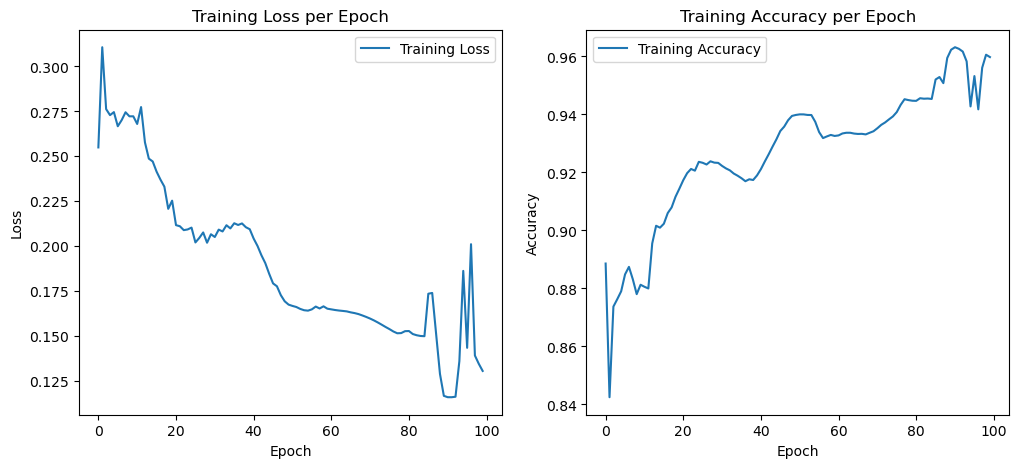

In [28]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_list, label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 绘制准确度曲线
plt.subplot(1, 2, 2)
plt.plot(acc_list, label='Training Accuracy')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Unseen test set performance

In [29]:
X_test_tensor = torch.tensor(X_test.values).float().unsqueeze(1).to(device)

model.eval()
outputs = model(X_test_tensor)
with torch.no_grad():
    probabilities = torch.sigmoid(outputs)
    predictions = (probabilities > 0.5).float().cpu().numpy()

    # Calculate indicators
    acc = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)

    print("Accuracy: ", acc, ", Precision: ", precision, ", Recall: ", recall, ", F1: ", f1)

Accuracy:  0.7576385382753879 , Precision:  0.3604440522086488 , Recall:  0.980788675429727 , F1:  0.5271560069291125
